# Sloan Digital Sky Survey Classification XG Boost

# About the SDSS

The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

For more information about this awesome project - please visit their website:

http://www.sdss.org/

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, cross_val_predict
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time

%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [3]:
sdss_df = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv')

# Data Exploration

In [4]:
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [5]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


In [6]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


In [8]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

# Data Filtering

http://www.sdss3.org/dr9/imaging/imaging_basics.php

In [9]:
sdss_df.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [10]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(5)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,3306,54922,512


# Univariate Analysis

### Redshift

Text(0.5, 1.0, 'QSO')

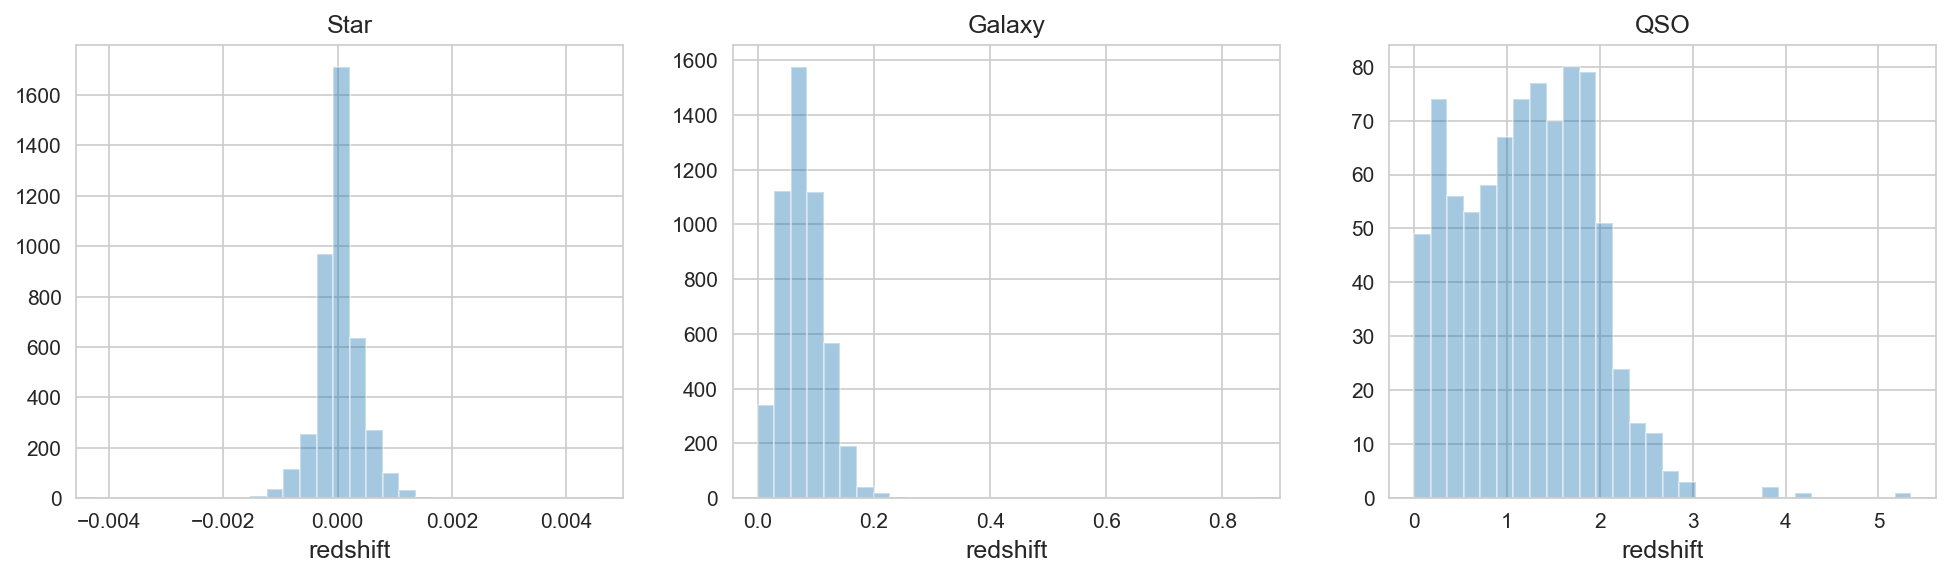

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax = sns.distplot(sdss_df[sdss_df['class']== 'STAR'].redshift, bins=30, ax=axes[0], kde=False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']== 'GALAXY'].redshift, bins=30, ax=axes[1], kde=False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']== 'QSO'].redshift, bins=30, ax=axes[2], kde=False)
ax.set_title('QSO')

This is an interesting result.

We can cleary tell that the redshift values for the classes quite differ.

   * **Star**: The histogram looks like a truncated zero-centered normal distribution.

   * **Galaxy**: The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075.

   * **QSO**: The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers.

### dec

Text(0.5, 1.0, 'dec')

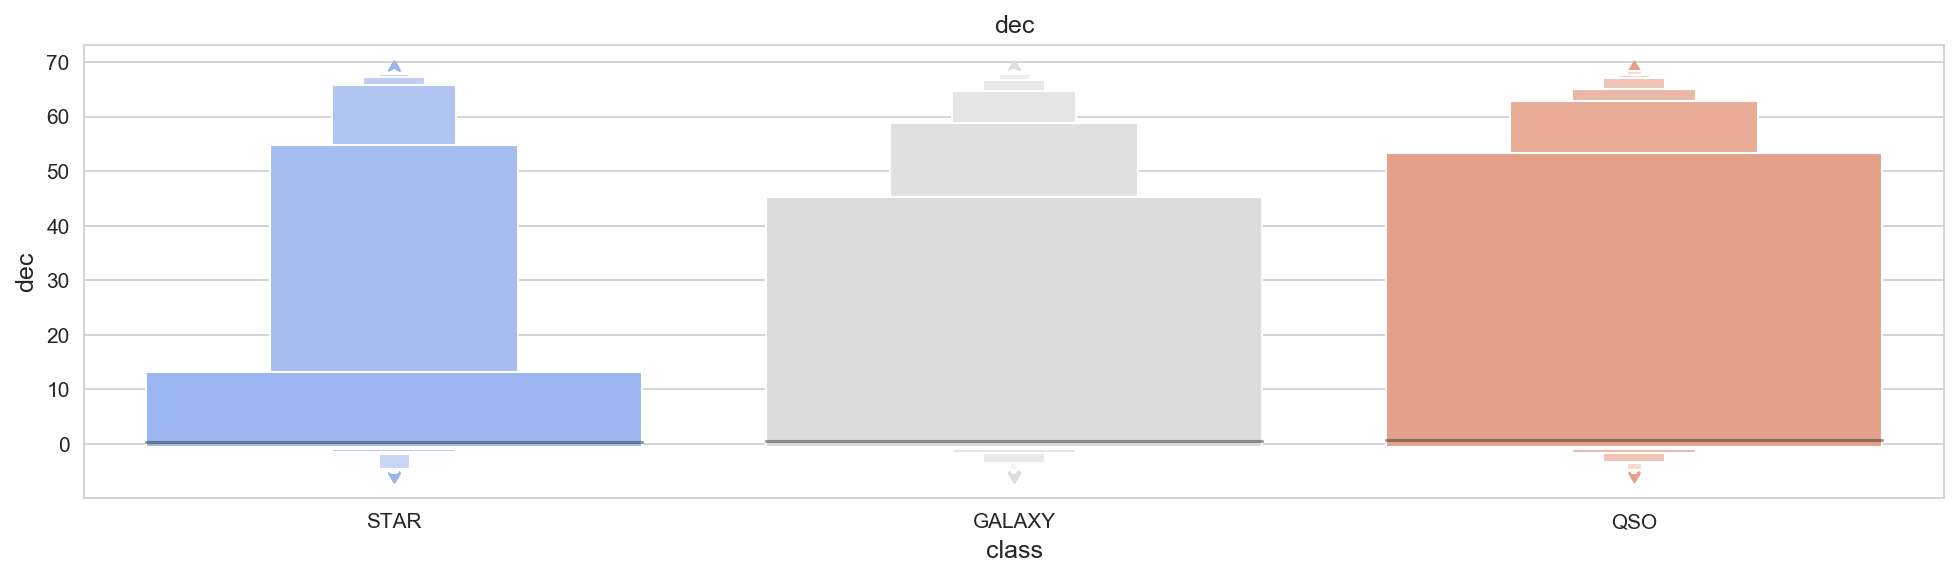

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=sdss_df['class'], y=sdss_df['dec'], palette='coolwarm')
ax.set_title('dec')

In this case we can observe a clear distinction between Stars and the other two classes. The difference between Galaxies and Quasars is smaller.

* Star: The largest part of the data points lay within a 0 to 10 range. Another large part consists of values between about 10 to 55. Only small amounts of the data are lower or higher than these ranges.

* Galaxy: The largest part of values lays between 0 and 45. There is a smaller amount of values in the range of 45 to 60. The rest of the data has smaller or higher values.

* QSO: This plot looks quite similiar to the GALAXY plot. Only the amount of data points in the range of 0 to 60 is even bigger.

***Side Note: The fact that the distribution of dec values of galaxies und quasar objects is almost the same might indicate that one can find both galaxies and quasars at smiliar positions in the night sky.***

# Multivariate Analysis

### u,g,r,i,z filters

Text(0.5, 1, 'QSO')

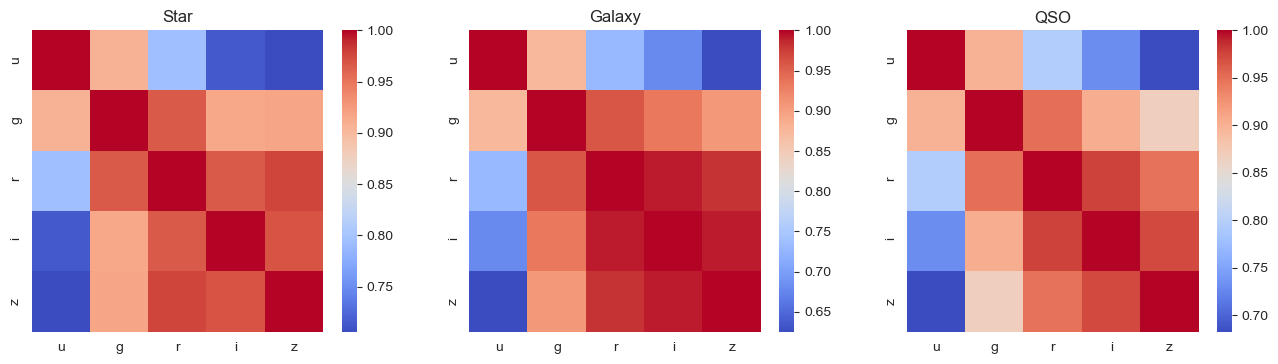

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)

ax = sns.heatmap(sdss_df[sdss_df['class']=='STAR'][['u','g','r','i','z']].corr(), ax=axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(sdss_df[sdss_df['class']=='GALAXY'][['u','g','r','i','z']].corr(), ax=axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_df[sdss_df['class']=='QSO'][['u','g','r','i','z']].corr(), ax=axes[2], cmap='coolwarm')
ax.set_title('QSO')

Right of the top we observe that the correlation matrices look very similiar for every class.

We can tell that there are high correlations between the different bands. This feels not really suprising - intuitively one would think that if one of the bands captures some object, the other bands should capture something aswell.

Therefore it is interesting to see that band 'u' is less correlated to the other bands.

Remember: u, g, r, i, z capture light at wavelengths of 354, 476, 628, 769 and 925 nm.

But: as we can see - the correlation is roughly the same for every class...the different bands behave the same for the different classes!

### Right ascension (ra) and declination (dec)

Text(0.5, 1, 'Equatorial coordinates')

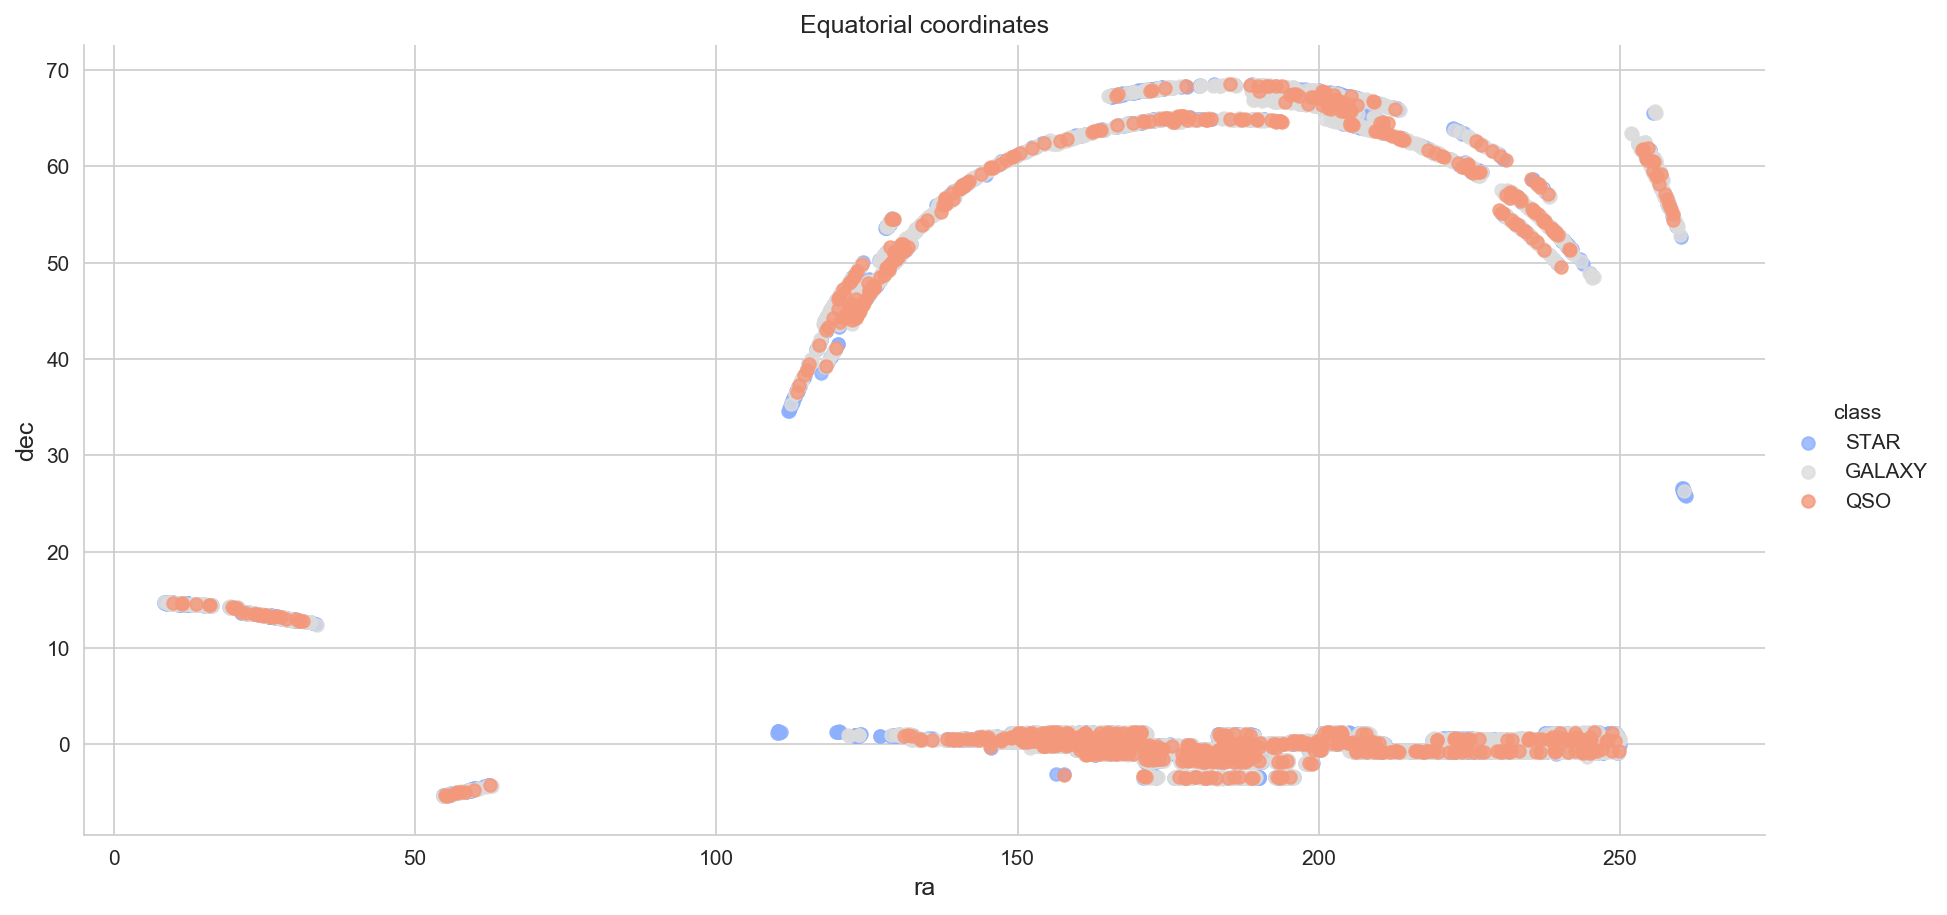

In [18]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', height=6, aspect=2)
plt.title('Equatorial coordinates')

All SDSS images cover the same area of the sky. The plot above tells us that stars, galaxies and quasars are observed equally at all coordinates within this area. So whereever the SDSS "looks" - the chance of observing a star or galaxy or quasar is always the same.

# Feature Engineering

In [19]:
from sklearn.decomposition import PCA

In [20]:
sdss_df_fe = sdss_df

le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

In [21]:
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

In [22]:
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)

In [23]:
sdss_df_fe.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid,0,1,2
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [24]:
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


# Machine Learning Models - Training

In [26]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

## XGBoost

In [28]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()

acc_xgb = (preds == y_test).sum().astype(float)/len(preds) * 100

xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 99.36
Time consumed for training: 2.441
Time consumed for prediction: 0.02504 seconds


In [30]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Random Forest

In [31]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.15
Time consumed for training: 0.384 seconds
Time consumed for prediction: 0.01245 seconds


## SVM

In [32]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 94.36
Time consumed for training: 1.103 seconds
Time consumed for prediction: 1.24410 seconds


# Comparing models

In [33]:
results = pd.DataFrame({
    'Model': [ 'XGBoost', 'Random Forest', 'SVC'],
    'Score': [acc_xgb, acc_rfc, acc_svc],
    'Runtime Training': [xgb_train_time, rfc_train_time, svc_train_time],
    'Runtime Prediction': [xgb_prediction_time, rfc_prediction_time,svc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
XGBoost,99.363636,2.440765,0.025044
Random Forest,99.151515,0.383600,0.012446
SVC,94.363636,1.102702,1.244101


# K Fold Cross Validation

We will only perform k fold cross valdiation for the top 2 classifiers, i.e. XGBoost & Random Forest.

### Random Forest

In [34]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99552239 0.99104478 0.9880597  0.99253731 0.99552239 0.99104478
 0.9880597  0.98656716 0.99104478 0.99253731]
Mean: 0.9911940298507462
Standard Deviation: 0.0028670705540744085


### XGBoost

In [35]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99701493 0.99253731 0.99253731 0.99253731 0.99850746 0.99253731
 0.99402985 0.99104478 0.98955224 0.99552239]
Mean: 0.9935820895522388
Standard Deviation: 0.0025894554586414287


**We trained different machine learning models to solve this classification problems. Without any further hyperparameter tuning XGBoost and Scikit-Learn's Random Forest Classifier performed the best.**

**As XGBoost showed a little higher accuracy in most of the tests, we will continue only with this classifier.**

In [36]:
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.889983
PCA_3,0.037975
PCA_1,0.015990
PCA_2,0.012986
fiberid,0.009974
ra,0.008999
dec,0.008731
mjd,0.007966
plate,0.007398


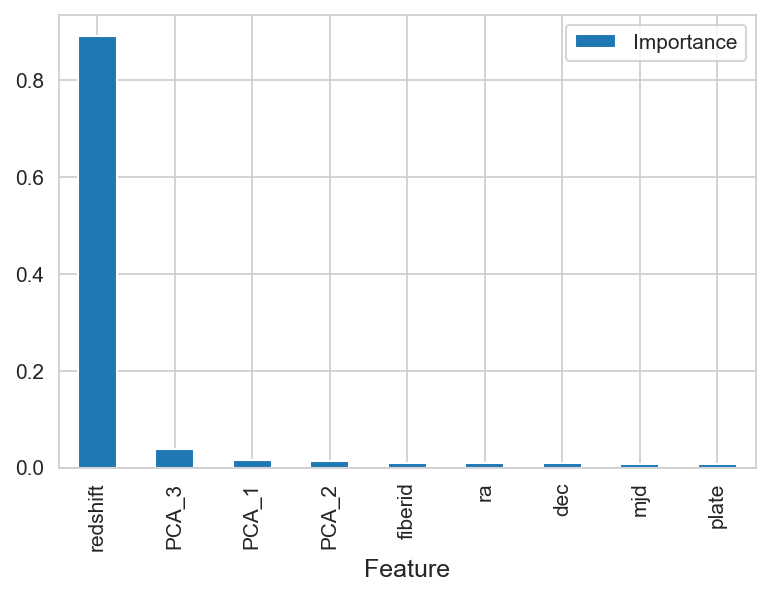

In [37]:
importances.plot.bar()

In [42]:
scaler = MinMaxScaler()
sdss = pd.DataFrame(scaler.fit_transform(sdss_df_fe.drop(['mjd', 'class'], axis=1)), columns=sdss_df_fe.drop(['mjd', 'class'], axis=1).columns)
sdss['class'] = sdss_df_fe['class']

In [43]:
sdss.head()

,ra,dec,redshift,plate,fiberid,PCA_1,PCA_2,PCA_3,class
0,0.693832,0.074025,0.000770,0.373281,0.490490,0.385886,0.069348,0.387685,2
1,0.694098,0.074642,0.000762,0.006999,0.540541,0.448110,0.215264,0.415556,2
2,0.694422,0.074519,0.023749,0.002579,0.512513,0.518964,0.154511,0.490959,0
3,0.695175,0.073487,0.000751,0.373281,0.509510,0.388785,0.279638,0.452852,2
4,0.695225,0.074199,0.000882,0.373281,0.511512,0.417103,0.357613,0.353918,2


# Confusion Matrix

In [45]:
predictions = cross_val_predict(xgb, sdss.drop('class', axis=1), sdss['class'], cv=3)
confusion_matrix(sdss['class'], predictions)

array([[4962,   29,    7],
       [  22,  827,    1],
       [   5,    0, 4147]], dtype=int64)

# Precision and Recall

In [46]:
print("Precision:", precision_score(sdss['class'], predictions, average='micro'))
print("Recall:",recall_score(sdss['class'], predictions, average='micro'))

Precision: 0.9936
Recall: 0.9936


# F1-score

In [47]:
print("F1-Score:", f1_score(sdss['class'], predictions, average='micro'))

F1-Score: 0.9936


# The End!